# Reproduce a revised Figure 16 of the 2016 JAMES Tracmip introduction paper

Attention: We only use those models that have correctly implemented land, plus CALTECH, which has delivered its landOrbit simulations later. Thus the figure generated here can differ from the Fig. 16 of the introduction paper.

We use approach 1 to access the Pangeo data in the Google Cloud. See load_data_from_pangeo.iypnb in the same folder.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs

## Data loading and climatolgical mean over last 20 years

Wrapper function to load data. Output is a dictionary of xarray data arrays.

In [2]:
def load_data(freq, var, exp):
    df = pd.read_csv('https://storage.googleapis.com/cmip6/tracmip.csv')
    # a somewhat cumbersome way to query the dataframe ... 
    df_var = df.query("frequency == \'"+freq+"\'").query("variable == \'"+var+"\'").query("experiment == \'"+exp+"\'")
    gcs = gcsfs.GCSFileSystem(token='anon')
    datadict = dict()
    for zstore in df_var.source.values:
        mapper = gcs.get_mapper(zstore)
        ds = xr.open_zarr(mapper, consolidated=True)
        ntime = ds.time.size # number of timestep
        ds_clim = ds.isel(time=slice(ntime-20*12, ntime)).groupby('time.month').mean('time')
         # write only variable of interest to dictionary, so this becomes a data array
        datadict[ds.attrs['model_id']] = ds_clim[var] 
    return datadict

In [3]:
pr_ldct = load_data('Amon', 'pr', 'landControl')
pr_ldor = load_data('Amon', 'pr', 'landOrbit')

Note: not all models have the landOrbit simulations. We are identifying those models that provide both the landControl and the landOrbit simulations.

In [4]:
print("Models that have both landControl and landOrbit simulations:\n", [k for k in pr_ldct if k in pr_ldor])

Models that have both landControl and landOrbit simulations:
 ['CALTECH', 'CAM3', 'CAM4', 'CNRM-AM5', 'ECHAM61', 'ECHAM63', 'LMDZ5A', 'MIROC5', 'MPAS', 'MetUM-CTL', 'MetUM-ENT']


Now we filter the landControl models for those that have the landOrbit simulation.

In [5]:
pr_ldct = { model: pr_ldct[model] for model in pr_ldor.keys() }

And we are removing those models that have an error in their implementation of land: ECHAM6.3, LMDZ5A, MetUM-CTL and MetUM-ENT.

In [6]:
for model in ['ECHAM63', 'LMDZ5A', 'MetUM-CTL', 'MetUM-ENT']:
    pr_ldct.pop(model)
    pr_ldor.pop(model)

## Interpolation to a common latitude-longitute 1deg x 1deg grid

In [7]:
# latintp is the latiudes on which data will be interpolated, likewise for lonintp
latintp  = np.linspace(-89.5, 89.5, 180)     
nlatintp = latintp.size
lonintp  = np.linspace(-179.0, 179.0, 180)     
nlonintp = lonintp.size

In [8]:
def make_latlon_interpolation(orig):
    from scipy.interpolate import griddata
    intp = np.zeros((12, nlatintp, nlonintp)) + np.nan
    orig = orig.roll(lon=(orig['lon'].size//2), roll_coords=True)
    auxlon = orig['lon'].values
    auxlon[0:orig['lon'].size//2] -= 360
    orig['lon'] = auxlon
    lat = orig['lat'].values
    lon = orig['lon'].values
    # grid of original model data      
    x, y   = np.meshgrid(lon, lat)
    # grid on which we interpolate
    xintp, yintp = np.meshgrid(lonintp, latintp)
    # interpolate data
    for mon in range(12):
        intp[mon] = griddata((x.ravel(), y.ravel()), orig[mon].values.ravel(), (xintp, yintp))
    return intp

We first interpolate landControl.

In [9]:
pr_ldct_intp = dict()
for model in pr_ldct.keys():
    pr_ldct_intp[model] = make_latlon_interpolation(pr_ldct[model])

We now interpolate landOrbit.

In [10]:
pr_ldor_intp = dict()
for model in pr_ldor.keys():
    pr_ldor_intp[model] = make_latlon_interpolation(pr_ldor[model])

## Build zonal-mean precipitation over land and ocean

In [11]:
print('We verify that lonintp[90:112] is the longitudes over land:', lonintp[90:112])

We verify that lonintp[90:112] is the longitudes over land: [ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19. 21. 23. 25. 27. 29. 31. 33. 35.
 37. 39. 41. 43.]


In [12]:
pr_ldct_intp_land = dict()
pr_ldct_intp_ocea = dict()
pr_ldor_intp_land = dict()
pr_ldor_intp_ocea = dict()

In [13]:
for model in pr_ldct_intp.keys():
    pr_ldct_intp_land[model] = np.nanmedian(pr_ldct_intp[model][:, :, 90:112], axis=2)
    pr_ldct_intp_ocea[model] = np.nanmedian(
        np.concatenate((pr_ldct_intp[model][:, :, 0:90], pr_ldct_intp[model][:, :, 112:]), axis=2), axis=2)
    
for model in pr_ldor_intp.keys():
    pr_ldor_intp_land[model] = np.nanmedian(pr_ldor_intp[model][:, :, 90:112], axis=2)
    pr_ldor_intp_ocea[model] = np.nanmedian(
        np.concatenate((pr_ldor_intp[model][:, :, 0:90], pr_ldor_intp[model][:, :, 112:]), axis=2), axis=2)

/home/fd8940/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


## Calculate monthly-mean ITCZ position for land and ocean regions

In [14]:
# calculate itcz position based on precip centroid between latboundary
def get_itczposition(pr, lat, latboundary, dlat):
    # pr: precipitation
    # lat: latitudes
    # latboundary: deg N/S that are used to calculate the precip centroid
    # dlat: latitude spacing of the fine interpolated grid
    area  = np.cos(lat*np.pi/180)
    xi    = np.arange(-latboundary, latboundary, dlat)
    # need to make sure that lat increases from SP to NP
    if lat[0]>lat[1]:
        lat = lat[::-1]
        pr  = pr [::-1]
    yi    = np.interp(xi, lat, pr)
    areai = np.interp(xi, lat, area)
    # area-integrated precip (up to constant factor)
    itcz = np.NaN
    nxi = len(xi)
    tot = np.sum(yi*areai)
    yiareai_int = np.zeros(nxi) + np.nan
    for j in range(0, nxi):
        yiareai_int[j] = np.sum(np.multiply(yi[0:j+1], areai[0:j+1]))
    ixi = np.argmin(np.abs(yiareai_int - 0.5*tot))
    itcz = xi[ixi]
    return itcz

In [15]:
month  = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
nmonth = month.size

In [16]:
itcz_ldct_land = dict()
for model in pr_ldct_intp_land.keys():
    temp = np.zeros(nmonth) + np.nan
    for t in range(nmonth):
        temp[t] = get_itczposition(pr_ldct_intp_land[model][t], latintp, 30, 0.1)
    itcz_ldct_land[model] = temp
    del temp

In [17]:
itcz_ldct_ocea = dict()
for model in pr_ldct_intp_ocea.keys():
    temp = np.zeros(nmonth) + np.nan
    for t in range(nmonth):
        temp[t] = get_itczposition(pr_ldct_intp_ocea[model][t], latintp, 30, 0.1)
    itcz_ldct_ocea[model] = temp
    del temp

In [18]:
itcz_ldor_land = dict()
for model in pr_ldor_intp_land.keys():
    temp = np.zeros(nmonth) + np.nan
    for t in range(nmonth):
        temp[t] = get_itczposition(pr_ldor_intp_land[model][t], latintp, 30, 0.1)
    itcz_ldor_land[model] = temp
    del temp

In [19]:
itcz_ldor_ocea = dict()
for model in pr_ldor_intp_ocea.keys():
    temp = np.zeros(nmonth) + np.nan
    for t in range(nmonth):
        temp[t] = get_itczposition(pr_ldor_intp_ocea[model][t], latintp, 30, 0.1)
    itcz_ldor_ocea[model] = temp
    del temp

## Plotting

In [20]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle

In [21]:
# dictionary for model names, model numbers and model colors used in TRACMIP plots
plotdict = {'AM21'        : {'color': np.array([255,204,153])/255, 'nbr':  '1', 'name': 'AM2.1'       },
            'CAM3'        : {'color': np.array([128,128,128])/255, 'nbr':  '2', 'name': 'CAM3'        },
            'CAM4'        : {'color': np.array([148,255,181])/255, 'nbr':  '3', 'name': 'CAM4'        },
            'CAM5Nor'     : {'color': np.array([194,  0,136])/255, 'nbr':  '4', 'name': 'CAM5Nor'     },
            'CNRM-AM5'    : {'color': np.array([  0, 51,128])/255, 'nbr':  '5', 'name': 'CNRM-AM5'    },
            'ECHAM61'     : {'color': np.array([  0,117,220])/255, 'nbr':  '6', 'name': 'ECHAM6.1'    },
            'ECHAM63'     : {'color': np.array([153, 63,  0])/255, 'nbr':  '7', 'name': 'ECHAM6.3'    },
            'GISS-ModelE2': {'color': np.array([157,204,  0])/255, 'nbr':  '8', 'name': 'GISS-ModelE2'},
            'LMDZ5A'      : {'color': np.array([ 76,  0, 92])/255, 'nbr':  '9', 'name': 'LMDZ5A'      },
            'MetUM-CTL'   : {'color': np.array([ 25, 25, 25])/255, 'nbr': '10', 'name': 'MetM-CTL'    },
            'MetUM-ENT'   : {'color': np.array([  0, 92, 49])/255, 'nbr': '11', 'name': 'MetUM-ENT'   },
            'MIROC5'      : {'color': np.array([ 43,206, 72])/255, 'nbr': '12', 'name': 'MIROC5'      },
            'MPAS'        : {'color': np.array([143,124,  0])/255, 'nbr': '13', 'name': 'MPAS'        },
            'CALTECH'     : {'color': np.array([255,164,  5])/255, 'nbr': '14', 'name': 'CALTECH'     }}

In [22]:
def make_niceplot(ax, modelname):
    ax.xaxis.set_ticks([-120, -60, 0, 60, 120])
    ax.xaxis.set_ticklabels([''], fontsize=11)
    ax.yaxis.set_ticks([-0.5, 0, 0.5])
    ax.yaxis.set_ticklabels([''], fontsize=11) 
    plt.text(0.03, 0.93, modelname, fontsize=15, ha='left', va='center', \
             transform=ax.transAxes, backgroundcolor='white')
    plt.xlim(-175, 175), plt.ylim(-0.6, 0.6) 

In [23]:
sinlat = np.sin(latintp*np.pi/180.0)

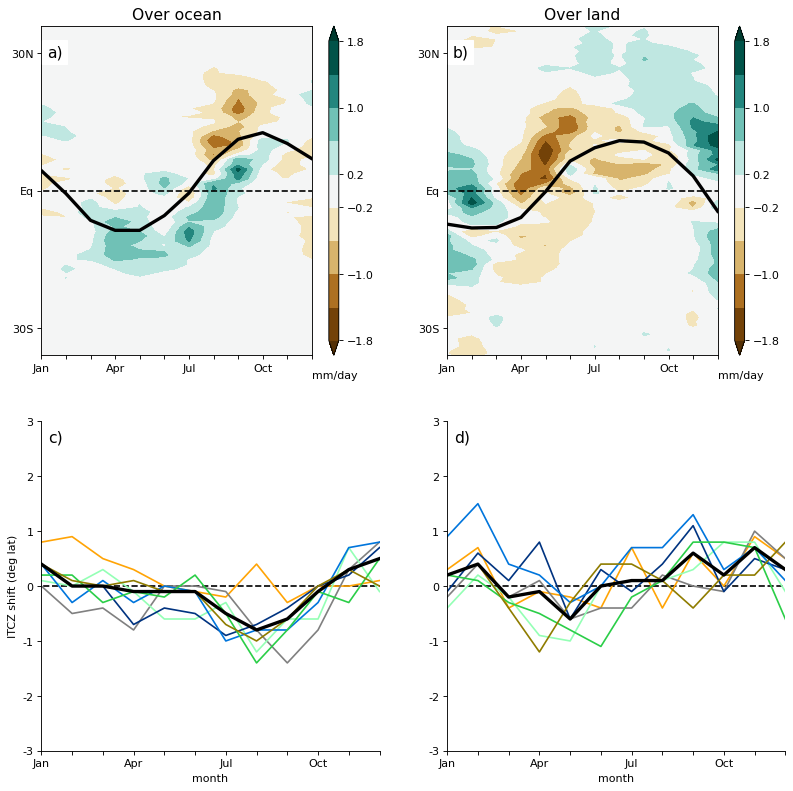

In [24]:
plt.figure(figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
clev = np.array([-1.8, -1.4, -1.0, -0.6, -0.2, 0.2, 0.6, 1.0, 1.4, 1.8])

ax = plt.subplot(2, 2, 1)
# calculate model medians
dpr_ocea = 86400*np.nanmedian([(pr_ldor_intp_ocea[model][:]-pr_ldct_intp_ocea[model][:]) 
                               for model in pr_ldor_intp_ocea.keys()], axis=0)
itcz_ocea = np.nanmedian([itcz_ldct_ocea[model][:] for model in itcz_ldct_ocea.keys()], axis=0)
c = plt.contourf(month, sinlat, np.transpose(dpr_ocea), clev, extend='both', cmap=cm.BrBG)
plt.plot([-200, 200], [0, 0], 'k--')
plt.plot(month, np.sin(itcz_ocea*np.pi/180), 'k', linewidth=3)
plt.title('Over ocean', fontsize=14)
plt.xlim(1, 12), plt.ylim(-0.6, 0.6)
ax.xaxis.set_ticks(month)
ax.xaxis.set_ticklabels(['Jan', '', '', 'Apr', '', '', 'Jul', '', '' ,'Oct', '', ''], fontsize=10)
ax.yaxis.set_ticks([-0.5, 0, 0.5])
ax.yaxis.set_ticklabels(['30S', 'Eq', '30N'], fontsize=10) 
plt.text(0.02, 0.92, 'a)', fontsize=14, ha='left', va='center', transform=ax.transAxes, backgroundcolor='white')
cbar = plt.colorbar(c, ticks=[-1.8, -1.0, -0.2, 0.2, 1.0, 1.8], orientation='vertical', aspect=30)
cbar.ax.tick_params(labelsize=10)
ax.text(1, -0.07, 'mm/day', fontsize=10, transform=ax.transAxes)

ax = plt.subplot(2, 2, 2)
# calculate model medians
dpr_land = 86400*np.nanmedian([(pr_ldor_intp_land[model][:]-pr_ldct_intp_land[model][:]) 
                               for model in pr_ldor_intp_ocea.keys()], axis=0)
itcz_land = np.nanmedian([itcz_ldct_land[model][:] for model in itcz_ldct_land.keys()], axis=0)
plt.contourf(month, sinlat, np.transpose(dpr_land), clev, extend='both', cmap=cm.BrBG)
plt.plot([-200, 200], [0, 0], 'k--')
plt.plot(month, np.sin(itcz_land*np.pi/180), 'k', linewidth=3)
plt.title('Over land', fontsize=14)
plt.xlim(1, 12), plt.ylim(-0.6, 0.6)
ax.xaxis.set_ticks(month)
ax.xaxis.set_ticklabels(['Jan', '', '', 'Apr', '', '', 'Jul', '', '' ,'Oct', '', ''], fontsize=10)
ax.yaxis.set_ticks([-0.5, 0, 0.5])
ax.yaxis.set_ticklabels(['30S', 'Eq', '30N'], fontsize=10) 
plt.text(0.02, 0.92, 'b)', fontsize=14, ha='left', va='center', transform=ax.transAxes, backgroundcolor='white')
cbar = plt.colorbar(c, ticks=[-1.8, -1.0, -0.2, 0.2, 1.0, 1.8], orientation='vertical', aspect=30)
cbar.ax.tick_params(labelsize=10)
ax.text(1, -0.07, 'mm/day', fontsize=10, transform=ax.transAxes)

ax = plt.subplot(2, 2, 3)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.plot([-100, 100], [0, 0], 'k--')
# model median
ditcz_ocea = np.nanmedian([(itcz_ldor_ocea[model][:]-itcz_ldct_ocea[model][:]) for model in itcz_ldct_ocea.keys()], axis=0)
for model in itcz_ldor_ocea.keys():
    plt.plot(month, (itcz_ldor_ocea[model]-itcz_ldct_ocea[model]), color=plotdict[model]['color'])
plt.plot(month, ditcz_ocea, 'k', linewidth=3)
plt.xlabel('month')
plt.ylabel('ITCZ shift (deg lat)')
plt.xlim(1, 12), plt.ylim(-3, 3)
ax.xaxis.set_ticks(month)
ax.xaxis.set_ticklabels(['Jan', '', '', 'Apr', '', '', 'Jul', '', '' ,'Oct', '', ''], fontsize=10)
ax.yaxis.set_ticks([-3, -2, -1, 0, 1, 2, 3])
ax.yaxis.set_ticklabels([-3, -2, -1, 0, 1, 2, 3], fontsize=10) 
plt.text(0.02, 0.95, 'c)', fontsize=14, ha='left', va='center', transform=ax.transAxes, backgroundcolor='white')

ax = plt.subplot(2, 2, 4)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.plot([-100, 100], [0, 0], 'k--')
# model median
ditcz_land = np.nanmedian([(itcz_ldor_land[model][:]-itcz_ldct_land[model][:]) for model in itcz_ldct_land.keys()], axis=0)
for model in itcz_ldor_land.keys():
    plt.plot(month, (itcz_ldor_land[model]-itcz_ldct_land[model]), color=plotdict[model]['color'])
plt.plot(month, ditcz_land, 'k', linewidth=3)
plt.xlabel('month')
plt.xlim(1, 12), plt.ylim(-3, 3)
ax.xaxis.set_ticks(month)
ax.xaxis.set_ticklabels(['Jan', '', '', 'Apr', '', '', 'Jul', '', '' ,'Oct', '', ''], fontsize=10)
ax.yaxis.set_ticks([-3, -2, -1, 0, 1, 2, 3])
ax.yaxis.set_ticklabels([-3, -2, -1, 0, 1, 2, 3], fontsize=10) 
plt.text(0.02, 0.95, 'd)', fontsize=14, ha='left', va='center', transform=ax.transAxes, backgroundcolor='white')

plt.tight_layout;